In [19]:
import cv2
import time
import random
import os

In [ ]:
def record(
    duration_seconds=20,
    camera_index=0,
    output_dir_original="original_capture",
    video_filename_prefix="original_video",
    image_filename_prefix="original_frame",
):
   
    if not os.path.exists(output_dir_original):
        try:
            os.makedirs(output_dir_original)
            print(f"Created directory for originals: {output_dir_original}")
        except OSError as e:
            print(f"Error creating directory {output_dir_original}: {e}")
            return None

    cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    if cap.set(cv2.CAP_PROP_AUTOFOCUS, 1):
        print("set autofocus")
    print(cap.get(cv2.CAP_PROP_FPS))
    print(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))


    timestamp = time.strftime("%Y%m%d_%H%M%S")
    original_video_filename = (
        f"{video_filename_prefix}_{timestamp}.mp4"
    )
    original_video_filepath = os.path.join(
        output_dir_original, original_video_filename
    )

    fourcc = cv2.VideoWriter_fourcc(*"mp4v") 
    out_original = cv2.VideoWriter(
        original_video_filepath, fourcc, 10, (1280, 720)
    )

    if not out_original.isOpened():
        print(f"Error: Could not open video writer for {original_video_filepath}")
        cap.release()
        return None

    print(f"Recording original video for {duration_seconds} seconds...")
    start_time = time.time()
    frames_written = 0

    while (time.time() - start_time) < duration_seconds:
        ret, frame = cap.read()
        if not ret:
            print("Error: Can't receive frame from camera.")
            break
        out_original.write(frame)
        frames_written += 1
    
    elapsed_time = time.time() - start_time
    print(f"Original recording finished. Duration: {elapsed_time:.2f}s. Frames: {frames_written}")

    cap.release()
    out_original.release()
    cv2.destroyAllWindows()

    if frames_written == 0:
        print("Error: No frames written to original video.")
        if os.path.exists(original_video_filepath): os.remove(original_video_filepath)
        return None
    return original_video_filepath
    

In [ ]:
if __name__ == "__main__":
   
    recording_duration = 5  
    camera_device_index = 0

    original_files_directory = "media_capture_original"
    original_video_prefix = "my_native_video"
    original_frame_prefix = "my_native_frame"


    original_video_path = record_and_extract_frame(
        duration_seconds=recording_duration,
        camera_index=camera_device_index,
        output_dir_original=original_files_directory,
        video_filename_prefix=original_video_prefix,
        image_filename_prefix=original_frame_prefix,
    )

    print("\n--- Script Finished ---")
    print(f"Returned paths:")
    print(f"  Original Video: {original_video_path}")

set autofocus
10.0
1280 720
Recording original video for 5 seconds...
Original recording finished. Duration: 5.03s. Frames: 39

--- Script Finished ---
Returned paths:
  Original Video: media_capture_original/my_native_video_20250529_210111.mp4


In [23]:
def take_photo_at_resolution(
    filename="",
    camera_index=0,
    desired_width=2560,
    desired_height=1440,
):
    """
    Captures a single photo from the specified camera at the desired resolution.
    """
    cap = cv2.VideoCapture(camera_index, cv2.CAP_V4L2)

    if not cap.isOpened():
        print(f"Error: Could not open video device at index {camera_index}.")
        return False
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)

    # Verify the resolution
    actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Actual resolution set by camera: {actual_width}x{actual_height}")

    if actual_width != desired_width or actual_height != desired_height:
        print(
            f"Warning: Camera did not use the exact desired resolution. "
            f"Using {actual_width}x{actual_height}."
        )

    if cap.set(cv2.CAP_PROP_AUTOFOCUS, 1):
        print("Autofocus enabled")
    else:
        print("Could not enable autofocus")

    print("Waiting for focus/exposure")
    time.sleep(5)
    for _ in range(5):
        ret, _ = cap.read() # Read and discard
        if not ret:
            print("Warning: Could not read a preparatory frame.")
            # Continue anyway, but the final image might not be optimal
            break
        time.sleep(0.5) # Small delay

    print("Capturing final image...")
    ret, frame = cap.read()
    cap.release()
    print("Camera released.")

    if ret and frame is not None:
        try:
            cv2.imwrite(filename, frame)
            print(f"Photo successfully saved as {filename}")
            return filename
        except Exception as e:
            print(f"Error: Could not save photo {filename}. Reason: {e}")
            return None
    else:
        print("Error: Could not capture frame. 'ret' was False or frame was None.")
        return None


In [24]:

if __name__ == '__main__':
    # --- Configuration ---
    output_filename = "captured_photo_high_res.jpg"
    # --- End Configuration ---

    success = take_photo_at_resolution(
        filename=output_filename,
        camera_index=0, # Use camera 0
        desired_width=2560,
        desired_height=1440
    )

    if success:
        print(f"Process complete. Check for '{output_filename}'.")
    else:
        print("Photo capture failed.")

Actual resolution set by camera: 2560x1440
Autofocus enabled
Waiting for focus/exposure
Capturing final image...
Camera released.
Photo successfully saved as captured_photo_high_res.jpg
Process complete. Check for 'captured_photo_high_res.jpg'.


In [ ]:
import cv2
from IPython.display import display, Image, clear_output
import time # Optional: for controlling frame rate slightly

def show_webcam_jupyter_with_resolution(desired_width=640, desired_height=480):
    # Attempt to capture video from the default camera (index 0)
    cap = cv2.VideoCapture(0, cv2.CAP_V4L2)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)
    # cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)
    # time.sleep(0.5)
    # if cap.set(cv2.CAP_PROP_AUTOFOCUS, 1):
    #     print("set autofocus")

    print(cap.get(cv2.CAP_PROP_FPS))
    actual_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    actual_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Actual resolution set by camera: {actual_width}x{actual_height}")

    print("Webcam feed started. To stop, interrupt the kernel (Kernel > Interrupt).")

    try:
        while True:
           
            ret, frame = cap.read()

            # if frame is read correctly ret is True
            if not ret:
                print("Error: Can't receive frame (stream end?). Exiting ...")
                break

            resolution_text = f"Res: {actual_width}x{actual_height}"
            cv2.putText(frame, resolution_text, (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            _, jpg_data = cv2.imencode('.jpg', frame)

            img = Image(data=jpg_data.tobytes())

            clear_output(wait=True)
            display(img)
            # Also print current resolution if you want it updated in text output
            # print(f"Streaming at: {actual_width}x{actual_height}")


            # Optional: Add a small delay to control frame rate
            # time.sleep(0.03) # Roughly 30 FPS

    except KeyboardInterrupt:
        print("Stream stopped by user (KeyboardInterrupt).")
    finally:
        # When everything done, release the capture
        if cap.isOpened():
            cap.release()
        print("Webcam released.")
        # No cv2.destroyAllWindows() needed

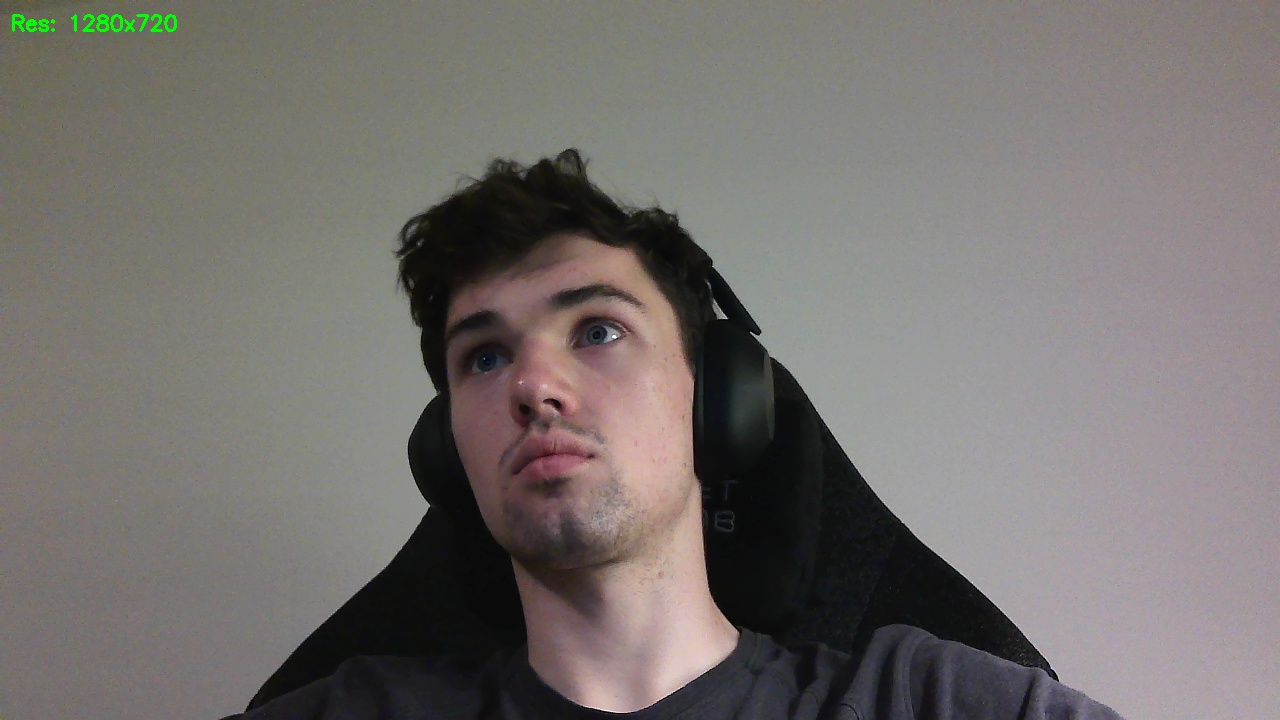

Stream stopped by user (KeyboardInterrupt).
Webcam released.


In [16]:
# To try for HD resolution (if your camera supports it)
show_webcam_jupyter_with_resolution(desired_width=1280, desired_height=720)
# show_webcam_jupyter_with_resolution(desired_width=2560, desired_height=1440)